In [8]:
import sys
from pathlib import Path
from IPython.display import display
from functools import partial
import pickle
import time
import datetime
                                                                           
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import ray
from ray import tune

import sklearn.metrics as skmetrics

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from nam.trainer import Trainer
from nam.data import NAMDataset
from nam.config import defaults
from nam.data import FoldedDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams

import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

# Prepare Dataset

In [2]:
with open('../data/all_data.pickle', 'rb') as file:
    all_data = pickle.load(file)

orig_characteristics = all_data['OrigCharacteristics.dta']
orig_characteristics_columns = [
    #'Deal',
    'type',
    'CutoffLTV',
    'CutoffDSCR',
    'CutoffCpn',
    'log_bal',
    'fixed',
    'buildingage',
    'CutoffOcc',
    # 'year_priced',
    'quarter_type',
    'AmortType',
    # 'MSA',
    # 'qy',
    'Size',

    'OVER_w',
    'past_over',
    'high_overstatement2', # is 100% dependent on Over_w, if we predict this we get 100% accuracy
    'Distress',
    #'non_perf'
]
orig_data = orig_characteristics[orig_characteristics_columns]
target_col = 'Distress'
orig_data_with_dummies = pd.get_dummies(
    orig_data,
    columns=[
        'AmortType',
        # 'MSA',
        'type',
        # 'year_priced'
    ]
)
clean_data = orig_data_with_dummies[
    orig_data_with_dummies.notna().all(axis=1)
]

dummy_cols = [col for col, dtype in clean_data.dtypes.items() if dtype == bool]
for dummy_col in dummy_cols:
    clean_data[dummy_col] = clean_data[dummy_col].map({True: 1, False:0})

# Percentage of clean data from whole dataset
print('percentage of clean data and all data ', len(clean_data) / len(orig_data_with_dummies))

y = clean_data[target_col]
X = clean_data.drop(columns=target_col)
feature_cols = X.columns
X['Distress'] = y
sample_size = len(y)
print('sample size ', sample_size)

percentage of clean data and all data  0.6194031714321389
sample size  24804


/var/folders/pr/tf6fbkqx6mv5m13cy7d765fw0000gn/T/ipykernel_11314/3234171030.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data[dummy_col] = clean_data[dummy_col].map({True: 1, False:0})


# Load hyperparameters for NAM

In [3]:
with open('../models/best_params_nam_maximize.joblib', 'rb') as file:
    hyper_params = joblib.load(file)['params']

config = defaults()
config.val_size = 0.0
config.test_size = 0.0
config.num_workers = 4
config.wandb = False
config.update(**hyper_params)

# NAM training

In [4]:
nam_dataset = NAMDataset(
    config,
    data_path=X,
    features_columns=feature_cols,
    targets_column='Distress',
)
nam_model = NAM(
    config=config,
    name='Final_NAM',
    num_inputs=len(nam_dataset[0][0]),
    num_units=get_num_units(config, nam_dataset.features)
)
litnam = LitNAM(config, nam_model)
trainer = pl.Trainer()
config.num_epochs = 1

data_loaders = nam_dataset.train_dataloaders()
for run, (train_loader, val_loader) in enumerate(data_loaders):
    print('run ', run)
    tb_logger = TensorBoardLogger(
        save_dir=config.logdir,
        name=f'{nam_model.name}',
        version=f'run{run + 1}')

    checkpoint_callback = ModelCheckpoint(
        filename=tb_logger.log_dir + "/{epoch:02d}-{val_loss:.4f}",
        monitor='val_loss',
        save_top_k=config.save_top_k,
        mode='max'
    )
    trainer = pl.Trainer(
        logger=tb_logger,
        max_epochs=config.num_epochs,
        callbacks=checkpoint_callback,
        log_every_n_steps=5
    )
    # y_test = torch.cat([batch[1] for batch in train_loader])
    # pd.DataFrame(y_test).hist()
    trainer.fit(
        litnam,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader)

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


run  0



  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 55.7 K
-------------------------------
55.7 K    Trainable params
0         Non-trainable params
55.7 K    Total params
0.223     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:103: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(
/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which m

Training: 0it [00:00, ?it/s]

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'AUROC_metric', 'AUROC_metric_step', 'train_loss_epoch', 'AUROC_metric_epoch', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)
`Trainer.fit` stopped: `max_epochs=1` reached.


# Evaluation

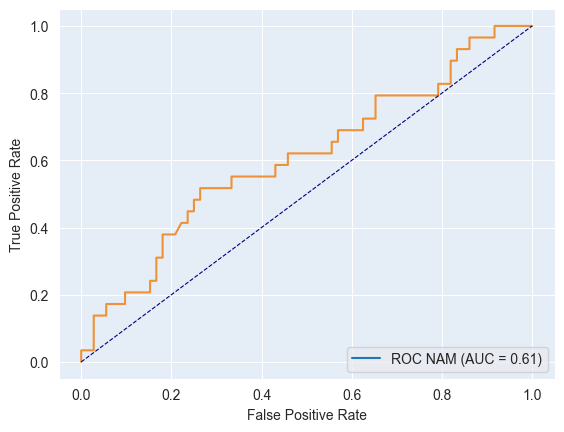

In [9]:
model = litnam.model
X.reset_index(drop=True, inplace=True)
sample_size = len(X)
model.eval()

with torch.no_grad() as grad:
    logits, fnns = model(torch.tensor(X.loc[:sample_size, feature_cols].values, dtype=torch.double))
    targets = torch.tensor(X.loc[:sample_size, 'Distress'].values, dtype=torch.double) 

y = targets.numpy()
pred = logits.numpy()

fpr, tpr, thresholds = skmetrics.roc_curve(y, pred)
roc_auc = skmetrics.auc(fpr, tpr)
display = skmetrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='ROC NAM')
sns.set_style('darkgrid')
display.plot()
display.line_.set_color('#F09135') 
fig = display.figure_
ax = display.ax_
# plot diagonal
ax.plot(np.linspace(0,1,2),np.linspace(0,1,2), linewidth=.8, linestyle='--', color='#00007B')
# ax.grid(color='lightblue')
ax.set_facecolor('#E5EDF6')
fig.savefig('../plots/NAM_ROC.png', format='png', bbox_inches='tight')

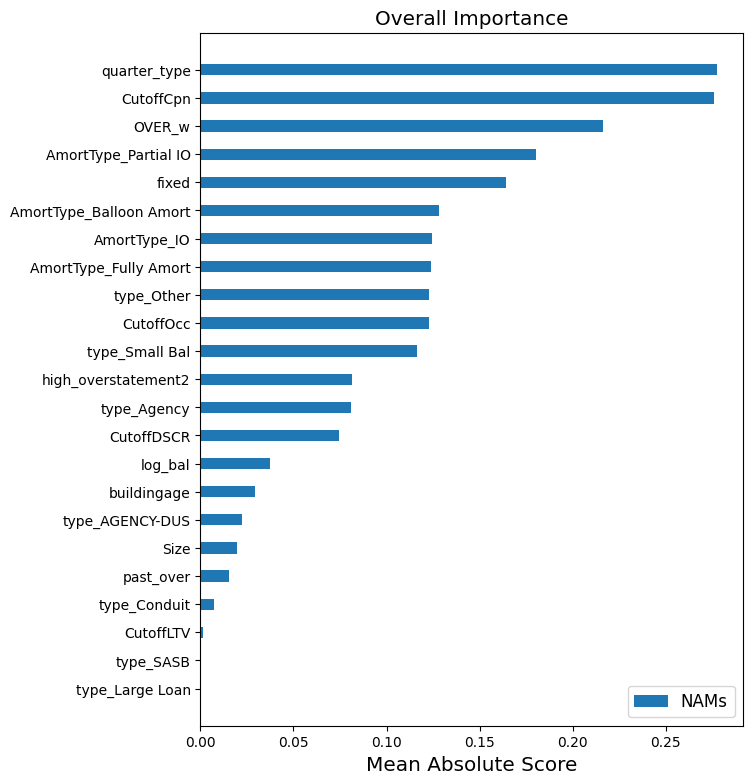

In [6]:
fig = plot_mean_feature_importance(litnam.model, nam_dataset, width=0.4)
fig.save('../plots/NAM_FeatureImportance.png', format='png')

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/nam/utils/graphing.py:165: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(min_x, max_x)


ValueError: num must be an integer with 1 <= num <= 21, not 22

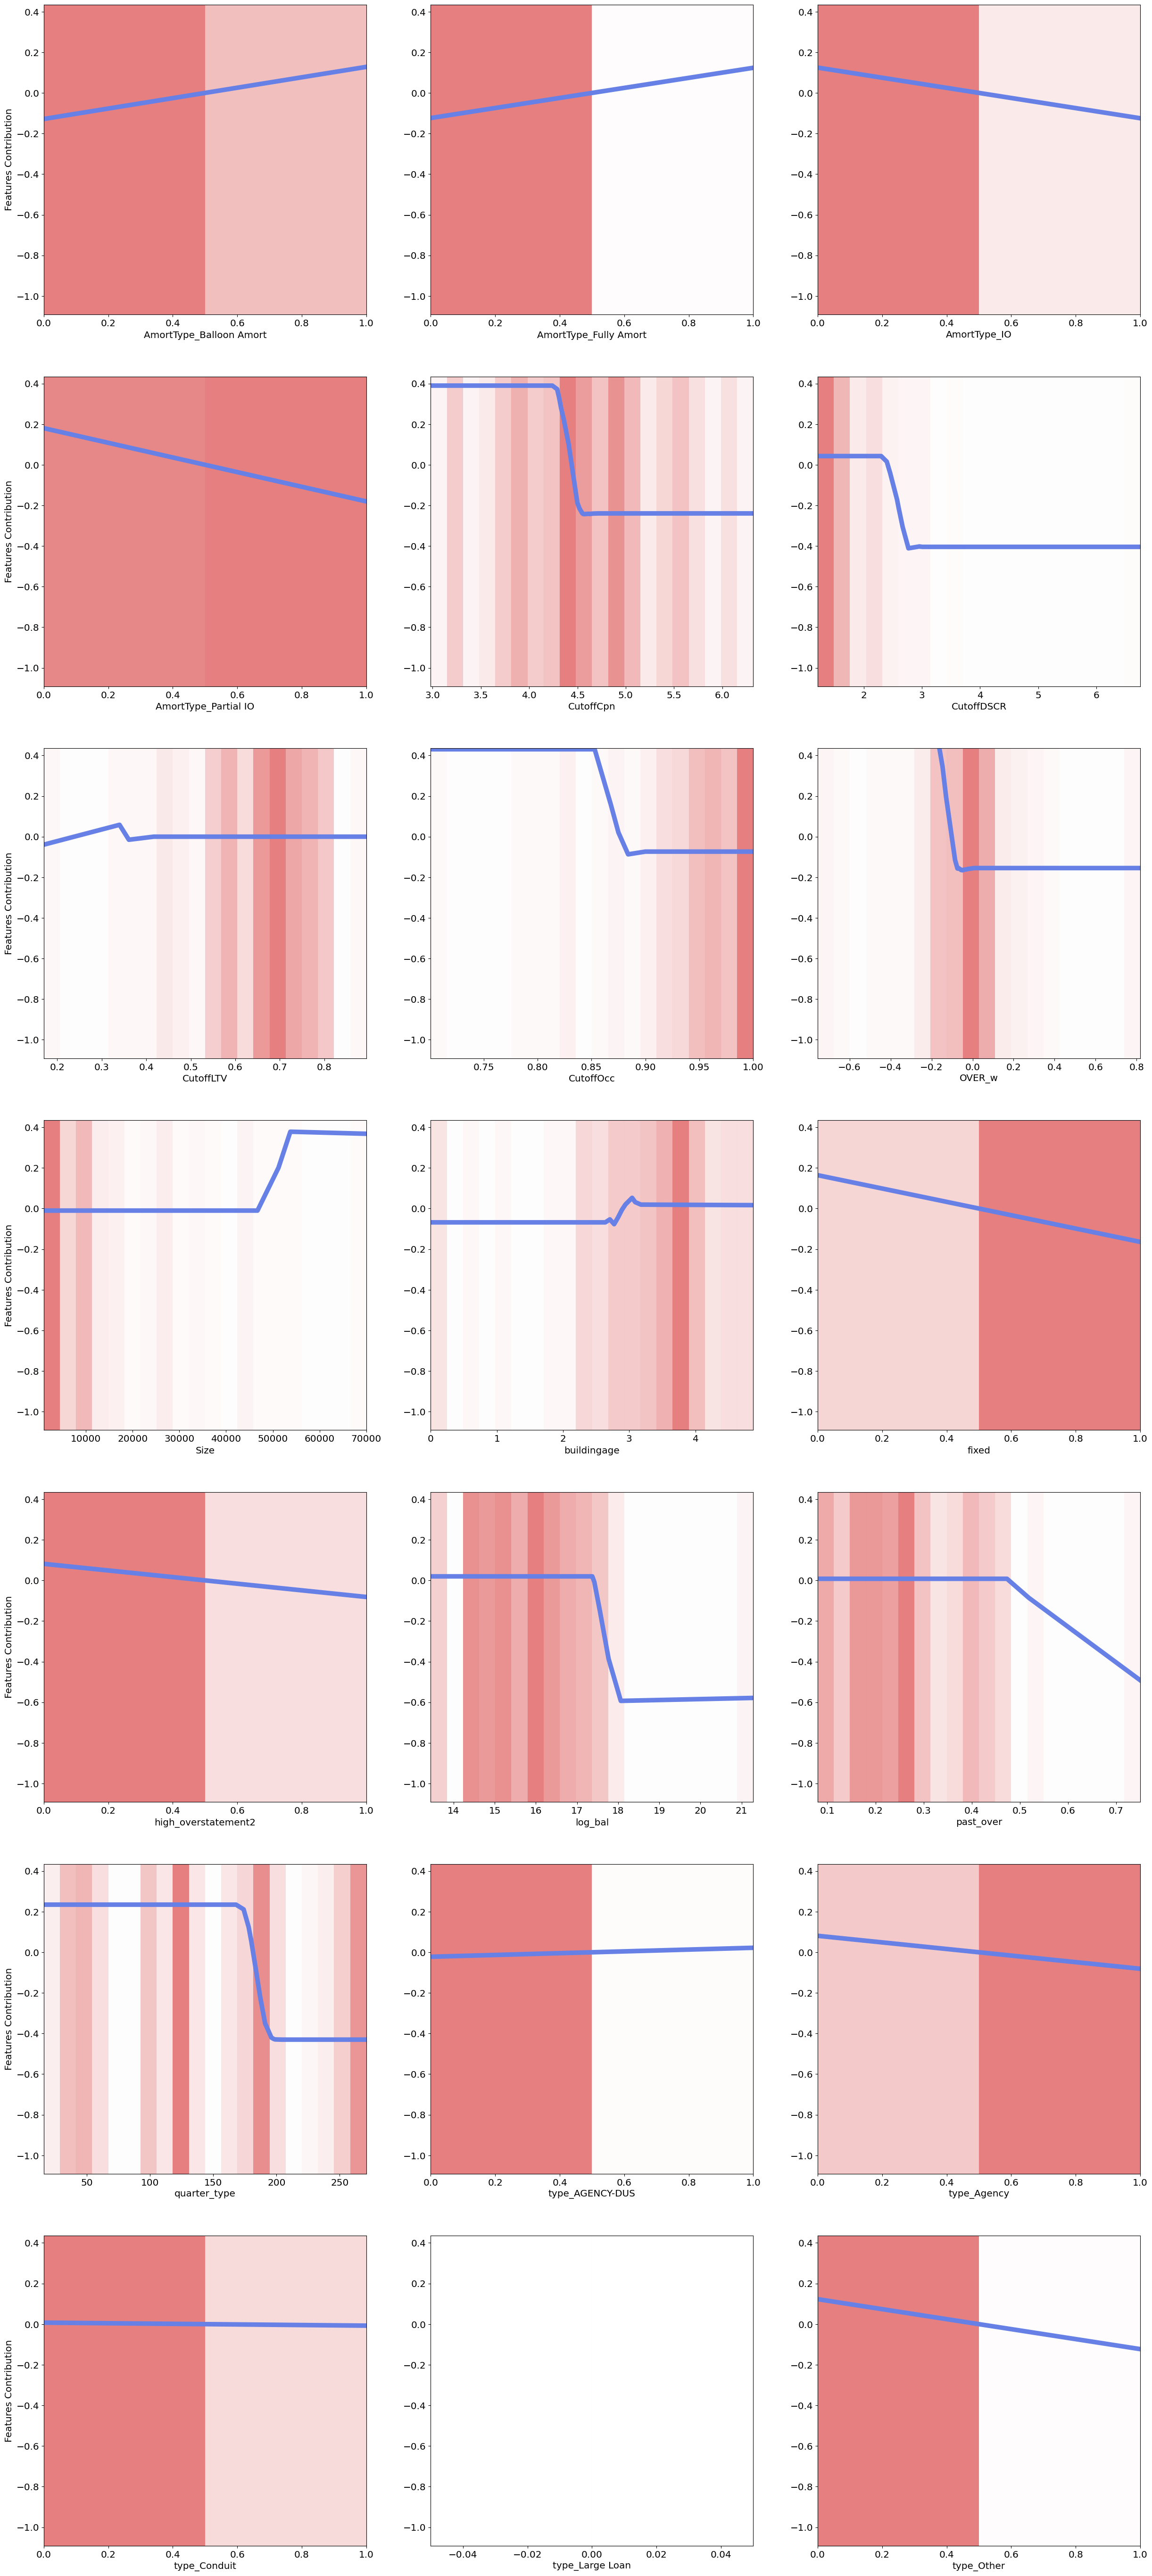

In [7]:
fig = plot_nams(litnam.model, nam_dataset, num_cols=3)